# Assignment-1
## Team: Aditya Ahuja (2020275), Deeptanshu Barman Chowdhuri (2020293)

##  Imports & Dataset

In [1]:
import torch
import requests
import os
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch.utils.data import Dataset
from torch.utils.data import random_split
import lightning as L
import matplotlib.pyplot as plt
import torchmetrics

In [2]:
device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

# device = "cpu"


In [3]:
Noise_0_dataframe = pd.read_csv("../Data/Assignment1/data_0_noise")
Noise_Low_dataframe = pd.read_csv("../Data/Assignment1/data_Low_noise")
Noise_High_dataframe = pd.read_csv("../Data/Assignment1/data_High_noise")

In [4]:
class_index = list(Noise_0_dataframe["era"].unique())
class_index_noise = list(Noise_Low_dataframe["era"].unique())
class_index_t10v_noise = list(Noise_Low_dataframe["target_10_val"].unique())

def encode(value, class_index = class_index):
    return class_index.index(value)

def encode_noise(value, class_index = class_index_noise):
    return class_index.index(value)

def encode_noise_t10v(value, class_index = class_index_t10v_noise):
    return class_index.index(value)


Noise_0_dataframe["era"] = Noise_0_dataframe["era"].apply(encode)
Noise_Low_dataframe["era"] = Noise_Low_dataframe["era"].apply(encode_noise)
Noise_High_dataframe["era"] = Noise_High_dataframe["era"].apply(encode_noise)
Noise_Low_dataframe["target_10_val"] = Noise_Low_dataframe["target_10_val"].apply(encode_noise_t10v)
Noise_High_dataframe["target_10_val"] = Noise_High_dataframe["target_10_val"].apply(encode_noise_t10v)

## Setting up Dataset & Dataloaders

In [5]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, noise, transform=None, target_transform=None, target=None, drop=None):
        self.dataframe = dataframe
        if drop != None:
            self.X = dataframe.drop(drop, axis=1).values
        else:
            self.X = dataframe.values
        self.y = dataframe[target].values
        self.transform = transform
        self.target_transform = target_transform
        self.noise = noise

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        item, label = self.X[idx], self.y[idx]
        return item, label

    def get_noise(self):
        return self.noise

In [6]:
#Setting up datasets
Noise_0_dataset_era = CustomDataset(Noise_0_dataframe, "0",drop = ["row_num","day","era","target_10_val","target_5_val"], target = "era")
Noise_Low_dataset_era = CustomDataset(Noise_Low_dataframe, "Low", drop = ["row_num","day","era","target_10_val","target_5_val","data_type"], target = "era")
Noise_High_dataset_era = CustomDataset(Noise_High_dataframe, "High", drop = ["row_num","day","era","target_10_val","target_5_val","data_type"], target = "era")
Noise_Low_dataset_t10v = CustomDataset(Noise_Low_dataframe, "Low", drop = ["row_num","day","era","target_10_val","target_5_val","data_type"], target = "target_10_val")
Noise_High_dataset_t10v = CustomDataset(Noise_High_dataframe, "High", drop = ["row_num","day","era","target_10_val","target_5_val","data_type"], target = "target_10_val")
Noise_0_train_era, Noise_0_test_era = random_split(Noise_0_dataset_era, [int(len(Noise_0_dataset_era)*0.8), int(len(Noise_0_dataset_era)*0.2)])
Noise_Low_train_era, Noise_Low_test_era = random_split(Noise_Low_dataset_era, [int(len(Noise_Low_dataset_era)*0.8), int(len(Noise_Low_dataset_era)*0.2)])
Noise_High_train_era, Noise_High_test_era = random_split(Noise_High_dataset_era, [int(len(Noise_High_dataset_era)*0.8), int(len(Noise_High_dataset_era)*0.2)])
Noise_Low_train_t10v, Noise_Low_test_t10v = random_split(Noise_Low_dataset_t10v, [int(len(Noise_Low_dataset_t10v)*0.8), int(len(Noise_Low_dataset_t10v)*0.2)])
Noise_High_train_t10v, Noise_High_test_t10v = random_split(Noise_High_dataset_t10v, [int(len(Noise_High_dataset_t10v)*0.8), int(len(Noise_High_dataset_t10v)*0.2)])

In [7]:
#Setting up dataloaders
Noise_0_era_train_loader = DataLoader(Noise_0_train_era, batch_size=64, shuffle=True)
Noise_0_era_test_loader = DataLoader(Noise_0_test_era, batch_size=64, shuffle=True)
########################################################################################
Noise_Low_era_train_loader = DataLoader(Noise_Low_train_era, batch_size=64, shuffle=True)
Noise_Low_era_test_loader = DataLoader(Noise_Low_test_era, batch_size=64, shuffle=True)
########################################################################################
Noise_High_era_train_loader = DataLoader(Noise_High_train_era, batch_size=64, shuffle=True)
Noise_High_era_test_loader = DataLoader(Noise_High_test_era, batch_size=64, shuffle=True)
########################################################################################
Noise_Low_t10v_train_loader = DataLoader(Noise_Low_train_t10v, batch_size=512, shuffle=True)
Noise_Low_t10v_test_loader = DataLoader(Noise_Low_test_t10v, batch_size=512, shuffle=True)
########################################################################################
Noise_High_t10v_train_loader = DataLoader(Noise_High_train_t10v, batch_size=512, shuffle=True)
Noise_High_t10v_test_loader = DataLoader(Noise_High_test_t10v, batch_size=512, shuffle=True)
########################################################################################


##  Cascade_Model

In [8]:
class MyMLP(torch.nn.Module):
    def __init__ (self, layers,activation = torch.nn.ReLU(), dropout = 0.5):
        super().__init__()
        linear = [torch.nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)]
        self.layers = []
        for i in range(len(linear)):
            if (i == len(linear)-1):
                self.layers.append(linear[i])
            else:
                self.layers.append(linear[i])
                self.layers.append(activation)
                if (dropout!=0): self.layers.append(torch.nn.Dropout(dropout))
        self.layers = torch.nn.Sequential(*self.layers)
        
        self.softmax = torch.nn.LogSoftmax(dim = 1)
        
    def forward(self, X):          
        X = self.layers(X)
        X = self.softmax(X)
        return X 

In [9]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10,verbose=True):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device).to(torch.float32), labels.to(device).to(torch.long)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_train_loss / len(train_loader)
        train_accuracy = correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device).to(torch.float32), labels.to(device).to(torch.long)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss = running_val_loss / len(val_loader)
        val_accuracy = correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train')
    plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()


In [ ]:
def cascading_mlp(train_loader,epochs=1,level=3,impurity=0.5):
    D_loader=train_loader
    for i in range(level):
        # declare a model
        Model = MyMLP(layers = [24,64,32,12], dropout=0).to(device)
        Model = Model.to(device)
        optimizer = torch.optim.Adam(Model.parameters(), lr=0.01)
        train_model(Model,torch.nn.NLLLoss(), optimizer,D_loader,D_loader,num_epochs=epochs)
        new_dataset=[]
        new_labelset=[]
        for inputs,labels in D_loader:
            inputs, labels = inputs.to(device).to(torch.float32), labels.to(device).to(torch.long)
            outputs = Model(inputs)
            gini=outputs@outputs.T
            gini=np.diag(gini)
            gini=1-gini
            for i in range(len(gini)):
                if gini[i]>impurity:
                    new_dataset.append(inputs[i])
                    new_labelset.append(labels[i])
            
                

    

MyMLP(
  (layers): Sequential(
    (0): Linear(in_features=24, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=12, bias=True)
  )
  (softmax): LogSoftmax(dim=1)
)
Epoch [1/200], Train Loss: 1.4798, Train Acc: 0.4617, Val Loss: 0.8932, Val Acc: 0.6769
Epoch [2/200], Train Loss: 0.7473, Train Acc: 0.7120, Val Loss: 0.6131, Val Acc: 0.7724
Epoch [3/200], Train Loss: 0.5905, Train Acc: 0.7702, Val Loss: 0.5377, Val Acc: 0.7692
Epoch [4/200], Train Loss: 0.5127, Train Acc: 0.7963, Val Loss: 0.4875, Val Acc: 0.8128
Epoch [5/200], Train Loss: 0.4526, Train Acc: 0.8125, Val Loss: 0.4075, Val Acc: 0.8519
Epoch [6/200], Train Loss: 0.3865, Train Acc: 0.8484, Val Loss: 0.3934, Val Acc: 0.8365
Epoch [7/200], Train Loss: 0.3836, Train Acc: 0.8503, Val Loss: 0.3234, Val Acc: 0.8821
Epoch [8/200], Train Loss: 0.3628, Train Acc: 0.8553, Val Loss: 0.2927, Val Acc: 0.8853
Epoch [9/200], T

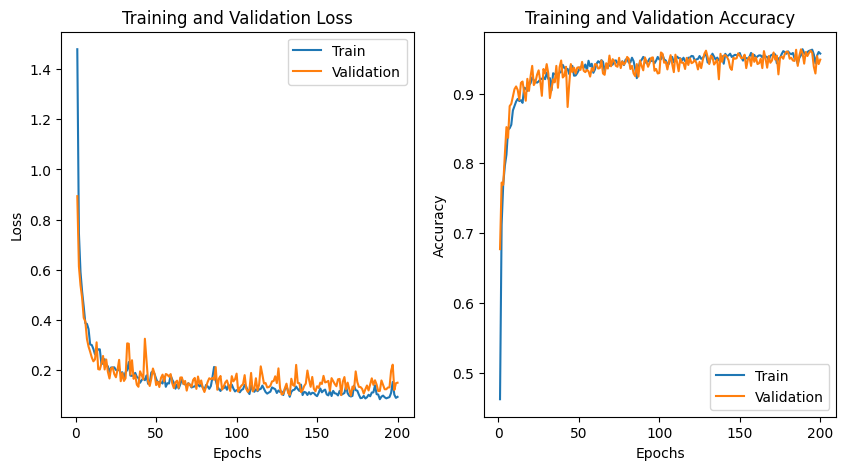

In [22]:
Model = MyMLP(layers = [24,64,32,12], dropout=0).to(device)
Model = Model.to(device)
print(Model)

train_model(Model,torch.nn.NLLLoss(), optimizer,Noise_0_era_train_loader, Noise_0_era_test_loader,num_epochs=200)

MyMLP(
  (layers): Sequential(
    (0): Linear(in_features=24, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=12, bias=True)
  )
  (softmax): LogSoftmax(dim=1)
)
Epoch [1/20], Train Loss: 0.8361, Train Acc: 0.6656, Val Loss: 0.6781, Val Acc: 0.7264
Epoch [2/20], Train Loss: 0.6751, Train Acc: 0.7243, Val Loss: 0.6417, Val Acc: 0.7402
Epoch [3/20], Train Loss: 0.6444, Train Acc: 0.7373, Val Loss: 0.6390, Val Acc: 0.7332
Epoch [4/20], Train Loss: 0.6271, Train Acc: 0.7442, Val Loss: 0.6157, Val Acc: 0.7475
Epoch [5/20], Train Loss: 0.6158, Train Acc: 0.7484, Val Loss: 0.6139, Val Acc: 0.7422
Epoch [6/20], Train Loss: 0.6066, Train Acc: 0.7523, Val Loss: 0.6020, Val Acc: 0.7585
Epoch [7/20], Train Loss: 0.6019, Train Acc: 0.7542, Val Loss: 0.6233, Val Acc: 0.7498
Epoch [8/20], Train Loss: 0.5971, Train Acc: 0.7570, Val Loss: 0.6094, Val Acc: 0.7519
Epoch [9/20], Train Loss

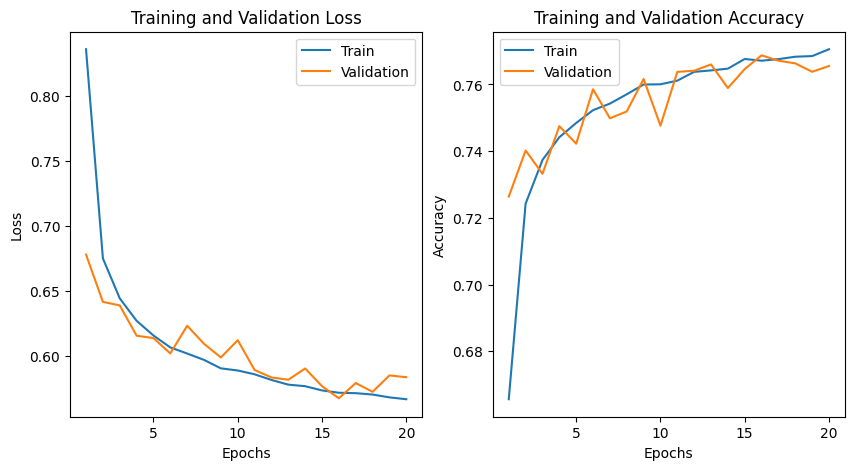

In [24]:
Model = MyMLP(layers = [24,64,32,12], dropout=0).to(device)
print(Model)
optimizer = torch.optim.Adam(Model.parameters(), lr=0.01, weight_decay=0)
train_model(Model,torch.nn.NLLLoss(), optimizer,Noise_Low_era_train_loader, Noise_Low_era_test_loader,num_epochs=20)

MyMLP(
  (layers): Sequential(
    (0): Linear(in_features=24, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=12, bias=True)
  )
  (softmax): LogSoftmax(dim=1)
)
Epoch [1/20], Train Loss: 1.4988, Train Acc: 0.4412, Val Loss: 1.3933, Val Acc: 0.4873
Epoch [2/20], Train Loss: 1.3653, Train Acc: 0.4862, Val Loss: 1.3610, Val Acc: 0.4855
Epoch [3/20], Train Loss: 1.3383, Train Acc: 0.4949, Val Loss: 1.3221, Val Acc: 0.4979
Epoch [4/20], Train Loss: 1.3261, Train Acc: 0.5000, Val Loss: 1.3095, Val Acc: 0.5092
Epoch [5/20], Train Loss: 1.3176, Train Acc: 0.5018, Val Loss: 1.3208, Val Acc: 0.5022
Epoch [6/20], Train Loss: 1.3110, Train Acc: 0.5045, Val Loss: 1.3435, Val Acc: 0.4901
Epoch [7/20], Train Loss: 1.3055, Train Acc: 0.5061, Val Loss: 1.3045, Val Acc: 0.5118
Epoch [8/20], Train Loss: 1.3018, Train Acc: 0.5072, Val Loss: 1.3130, Val Acc: 0.5020
Epoch [9/20], Train Loss

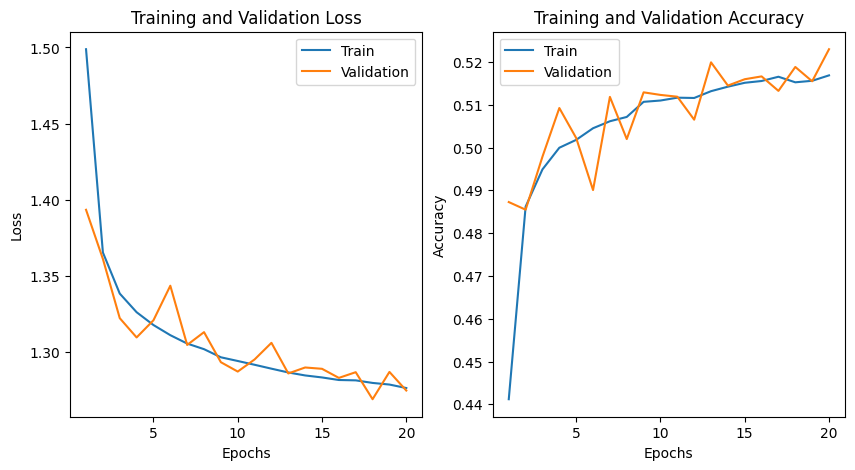

In [25]:
Model = MyMLP(layers = [24,64,32,12], dropout=0).to(device)
print(Model)
optimizer = torch.optim.Adam(Model.parameters(), lr=0.01, weight_decay=0)
train_model(Model,torch.nn.NLLLoss(), optimizer,Noise_High_era_train_loader, Noise_High_era_test_loader,num_epochs=20)

MyMLP(
  (layers): Sequential(
    (0): Linear(in_features=24, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=5, bias=True)
  )
  (softmax): LogSoftmax(dim=1)
)
Epoch [1/20], Train Loss: 0.6984, Train Acc: 0.7365, Val Loss: 0.5726, Val Acc: 0.7842
Epoch [2/20], Train Loss: 0.5517, Train Acc: 0.7899, Val Loss: 0.5281, Val Acc: 0.7990
Epoch [3/20], Train Loss: 0.5175, Train Acc: 0.8009, Val Loss: 0.5240, Val Acc: 0.7978
Epoch [4/20], Train Loss: 0.5019, Train Acc: 0.8072, Val Loss: 0.5068, Val Acc: 0.8016
Epoch [5/20], Train Loss: 0.4924, Train Acc: 0.8093, Val Loss: 0.4938, Val Acc: 0.8082
Epoch [6/20], Train Loss: 0.4851, Train Acc: 0.8112, Val Loss: 0.4827, Val Acc: 0.8134
Epoch [7/20], Train Loss: 0.4797, Train Acc: 0.8126, Val Loss: 0.4864, Val Acc: 0.8096
Epoch [8/20], Train Loss: 0.4739, Train Acc: 0.8153, Val Loss: 0.4846, Val Acc: 0.8093
Epoch [9/20], Train Loss:

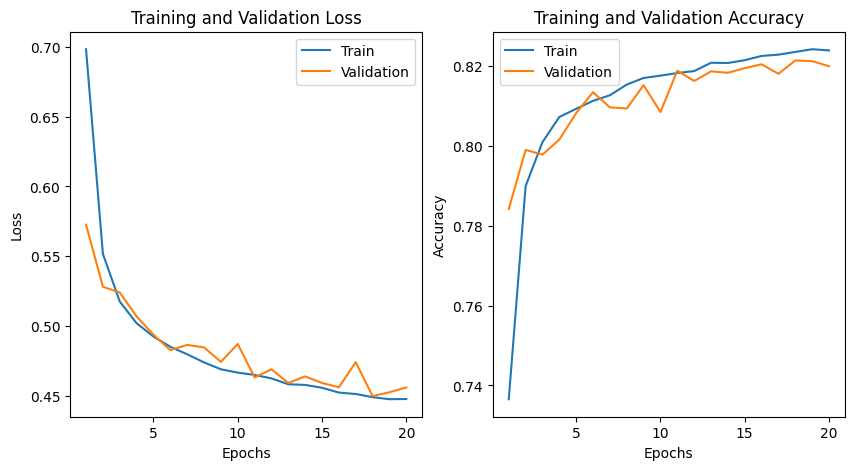

In [25]:
Model = MyMLP(layers = [24,64,32,5], dropout=0).to(device)
print(Model)
optimizer = torch.optim.Adam(Model.parameters(), lr=0.01, weight_decay=0)
train_model(Model,torch.nn.NLLLoss(), optimizer,Noise_Low_t10v_train_loader, Noise_Low_t10v_test_loader,num_epochs=20)

MyMLP(
  (layers): Sequential(
    (0): Linear(in_features=24, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=5, bias=True)
  )
  (softmax): LogSoftmax(dim=1)
)
Epoch [1/20], Train Loss: 1.0336, Train Acc: 0.5718, Val Loss: 0.9469, Val Acc: 0.6124
Epoch [2/20], Train Loss: 0.9200, Train Acc: 0.6166, Val Loss: 0.9084, Val Acc: 0.6197
Epoch [3/20], Train Loss: 0.8917, Train Acc: 0.6266, Val Loss: 0.8900, Val Acc: 0.6264
Epoch [4/20], Train Loss: 0.8750, Train Acc: 0.6325, Val Loss: 0.8772, Val Acc: 0.6322
Epoch [5/20], Train Loss: 0.8626, Train Acc: 0.6360, Val Loss: 0.8684, Val Acc: 0.6352
Epoch [6/20], Train Loss: 0.8562, Train Acc: 0.6392, Val Loss: 0.8575, Val Acc: 0.6396
Epoch [7/20], Train Loss: 0.8501, Train Acc: 0.6408, Val Loss: 0.8579, Val Acc: 0.6367
Epoch [8/20], Train Loss: 0.8463, Train Acc: 0.6418, Val Loss: 0.8589, Val Acc: 0.6387
Epoch [9/20], Train Loss:

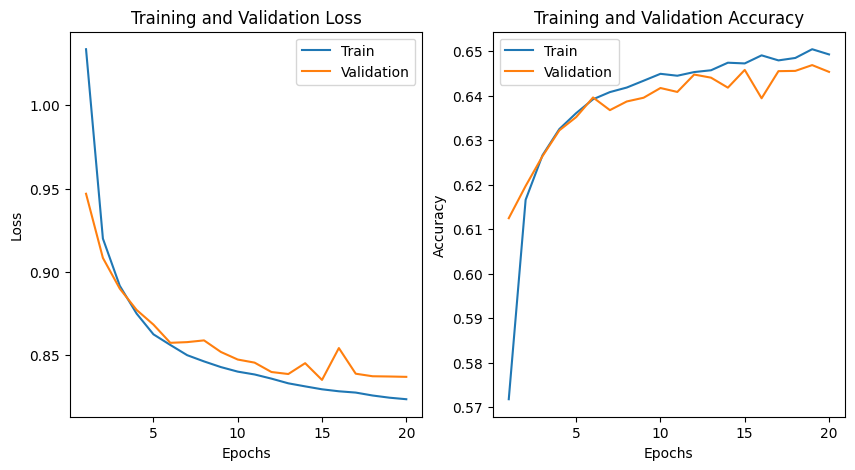

In [26]:
Model = MyMLP(layers = [24,64,32,5], dropout=0).to(device)
print(Model)
optimizer = torch.optim.Adam(Model.parameters(), lr=0.01, weight_decay=0)
train_model(Model,torch.nn.NLLLoss(), optimizer,Noise_High_t10v_train_loader, Noise_High_t10v_test_loader,num_epochs=20)